## This notebook is for implementing a prediction method for hotel bookings.
The implementation takes notes from:
1. Webb, T., Schwartz, Z., Xiang, Z. and Singal, M., 2020. Revenue management forecasting: the resiliency of advanced booking methods given dynamic booking windows. International Journal of Hospitality Management, 89, p.102590.
2. Zhang, Y., 2019. Forecasting hotel demand using machine learning approaches (Doctoral dissertation, Cornell University).

The data is originally from Antonio, N., de Almeida, A. and Nunes, L., 2019. Hotel booking demand datasets. Data in brief, 22, pp.41-49.   
More detailed explanation for the variables can be seen there.


In [334]:
import numpy as np
import pandas as pd
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

### Quick data exploration

In [335]:
data = pd.read_csv("../Data/hotel_bookings.csv")
data.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [336]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


In [337]:
data['hotel'].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

## Take only the relevant data for our use case.  
We take all the reservations, expect the ones that were canceled.
Then we'll only take the date with leadtimes <180, to reduce complexity of the models.

In [338]:
df = data.query('is_canceled == 0 and hotel == "City Hotel"')[['lead_time','arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month']]
df["date"] = pd.to_datetime(df['arrival_date_day_of_month'].astype(str) +'-'+ df['arrival_date_month'].astype(str)+'-'+ df['arrival_date_year'].astype(str),infer_datetime_format=True)
df = df[['lead_time','date']]
df = df.groupby(['date','lead_time',]).size().reset_index().pivot(index="date", columns="lead_time").fillna(0)
df=df.droplevel(0, axis=1).iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1].reset_index().iloc[:,:182]
df = df.rename(columns={col: 'ROH_'+str(col) 
                        for col in df.columns if col not in ['date']})
df['weekday'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year
df

lead_time,date,ROH_0,ROH_1,ROH_2,ROH_3,ROH_4,ROH_5,ROH_6,ROH_7,ROH_8,...,ROH_174,ROH_175,ROH_176,ROH_177,ROH_178,ROH_179,ROH_180,weekday,month,year
0,2015-07-01,65.0,65.0,65.0,65.0,65.0,65.0,65.0,64.0,64.0,...,64.0,64.0,64.0,64.0,64.0,64.0,64.0,Wednesday,July,2015
1,2015-07-02,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Thursday,July,2015
2,2015-07-03,10.0,10.0,10.0,10.0,10.0,9.0,9.0,9.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday,July,2015
3,2015-07-04,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,Saturday,July,2015
4,2015-07-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Monday,July,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,2017-08-27,79.0,72.0,65.0,65.0,64.0,64.0,64.0,62.0,62.0,...,18.0,18.0,17.0,17.0,16.0,16.0,16.0,Sunday,August,2017
784,2017-08-28,106.0,103.0,103.0,103.0,102.0,101.0,101.0,100.0,100.0,...,80.0,80.0,80.0,80.0,80.0,80.0,80.0,Monday,August,2017
785,2017-08-29,60.0,54.0,52.0,52.0,52.0,52.0,50.0,49.0,49.0,...,19.0,19.0,19.0,19.0,18.0,17.0,17.0,Tuesday,August,2017
786,2017-08-30,34.0,33.0,33.0,33.0,33.0,32.0,32.0,32.0,31.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,Wednesday,August,2017


In [339]:
df.describe()

lead_time,ROH_0,ROH_1,ROH_2,ROH_3,ROH_4,ROH_5,ROH_6,ROH_7,ROH_8,ROH_9,...,ROH_172,ROH_173,ROH_174,ROH_175,ROH_176,ROH_177,ROH_178,ROH_179,ROH_180,year
count,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,...,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000
mean,58.664975,55.065990,52.994924,51.722081,50.576142,49.408629,48.379442,47.436548,46.623096,45.879442,...,8.649746,8.558376,8.474619,8.364213,8.236041,8.153553,8.052030,7.972081,7.875635,2016.081218
std,27.278077,27.045554,26.960604,26.909235,26.749638,26.683291,26.681984,26.656596,26.565999,26.495128,...,16.262824,16.202590,16.170961,16.115233,16.026903,15.973788,15.939644,15.891763,15.843413,0.727742
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,39.000000,35.000000,33.000000,32.000000,31.000000,29.000000,28.750000,27.750000,27.000000,26.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000
50%,59.000000,55.000000,53.000000,52.000000,50.000000,49.000000,48.000000,47.000000,46.000000,45.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2016.000000
75%,74.250000,71.000000,69.000000,67.000000,66.000000,65.250000,64.000000,63.250000,63.000000,62.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,9.000000,2017.000000
max,204.000000,203.000000,203.000000,203.000000,201.000000,200.000000,200.000000,200.000000,200.000000,199.000000,...,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,2017.000000


## Now we have the data as we want it

<AxesSubplot:xlabel='date', ylabel='ROH_0'>

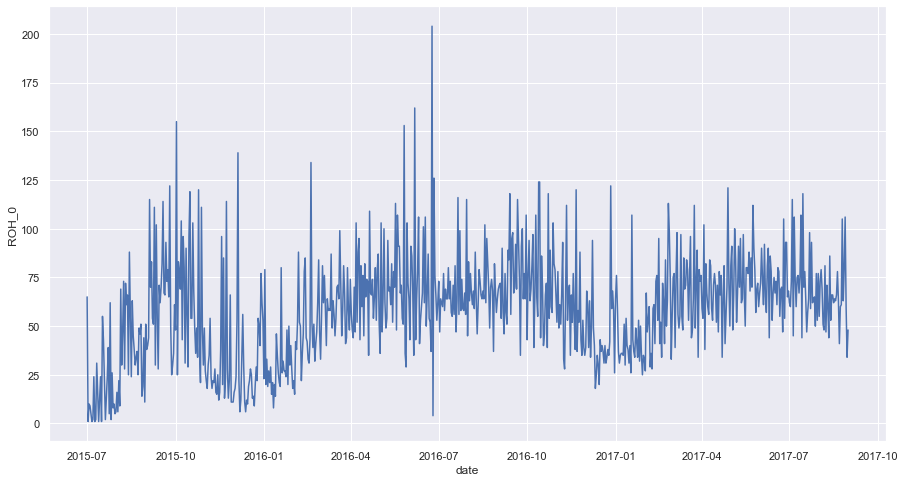

In [340]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=df,x='date',y='ROH_0')

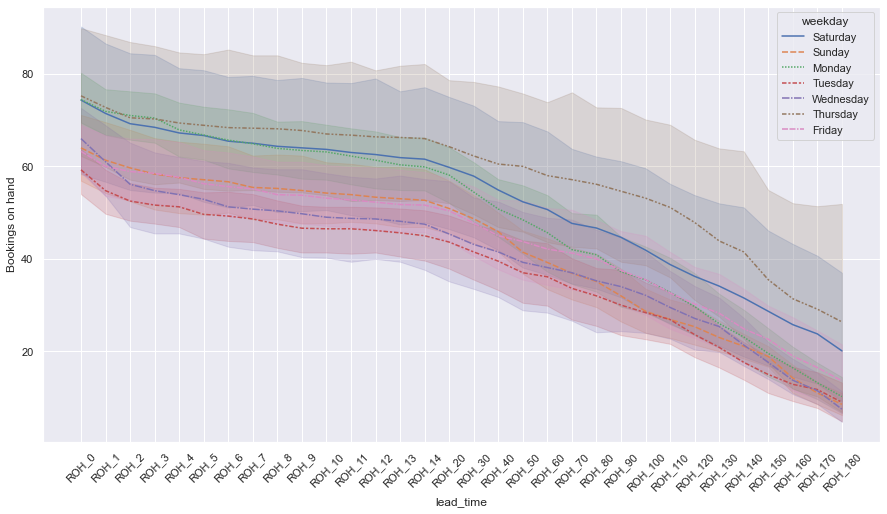

In [341]:
sns.set(rc = {'figure.figsize':(15,8)})
example_booking_curve = df[(df['date']>'2016-07-01') & (df['date']<'2016-08-30')].drop(columns=['date','month','year'])
# example_booking_curve
example_booking_curve=example_booking_curve.T
example_booking_curve.columns = example_booking_curve.iloc[181,:]
sns.lineplot(data=example_booking_curve[0:15].append(example_booking_curve[20::10]))
plt.ylabel('Bookings on hand')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);


There is a significant difference in the booking curves between weekdays, but even within them.   
Weekends have higher ROH throughout the lead times.

## Next we'll implement the prediction model
This will take care of the missing values as we predict further into the future.
Later, we can implement xgboost for the booking curves, and a naive time series prediction for just the final bookings.   
These can the be combined using weighted average.   
For xgboost, we can test if we can add simulated samples with missing values, to imitate the future that is unknown.

In [342]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

import statsmodels.api as sm

In [343]:
n_lead_time_max = 182
df_modeling = df.iloc[:,np.r_[:n_lead_time_max, -3:0]].query('date < "2017-01-01"')
df_test_ts = df.iloc[:,np.r_[:n_lead_time_max, -3:0]].drop(df_modeling.index)


In [344]:
df_frac = df_modeling.sample(frac = 0.6) # Fraction of the data will have missing values
rest_part = df_modeling.drop(df_frac.index)

def fill_ROH_na(row,days_ahead = 7):
    """Function for filling some curves with nan values.
    This is done to give the model a learning opportunity to be able to predict future values given missing ROH values.
    We will only fill ROH_1-ROH_14 with missing values, as we want to be able to predict 14 days into the future"""
    fill_until = np.random.randint(low=3,high=days_ahead+2)
    row[2:fill_until] = np.nan
    return row

df_frac = df_frac.apply(fill_ROH_na,axis=1)
df_sampled = pd.concat([df_frac, rest_part], ignore_index=True)

y = df_sampled.pop("ROH_0")
# y = df_sampled["ROH_0"]
X = df_sampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# preprocessor doesn't work with new indices, need to rest all. WHY? 
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

train_dates = X_train.pop('date')
test_dates = X_test.pop('date')
cat_idx = [X_train.columns.get_loc(c) for c in ['weekday','month','year'] if c in X_train]
num_idx = [x for x in range(len(X_train.columns)) if x not in cat_idx]
preprocessor_categorical = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_idx)
    ],
    remainder='passthrough'
)

X_train = preprocessor_categorical.fit_transform(X_train)
X_test = preprocessor_categorical.transform(X_test)


In [345]:
DTrain = xgb.DMatrix(X_train, y_train,feature_names=preprocessor_categorical.get_feature_names())
Dtest = xgb.DMatrix(X_test, y_test,feature_names=preprocessor_categorical.get_feature_names())

## Prediction algorithm

- Take the test data   
- Set current date 31.12.2016
- Take the next n days (rows)
- Set the unknown future values to nan, depending on the current date -> if 1.2.2017: set ROH_0 to nan, 2.2 set ROH_0 & ROH_1 to nan...
- Predict the n rows
- Set current date to n days into the future and repeat the process



In [346]:
def iter_validation(df,model,preprocessor,days_ahead = 7,plot_=True):
    preds = np.array([],dtype='float32')
    dates = np.array([],dtype='datetime64')
    current_date = pd.Timestamp("2016-12-31")
    while current_date <= df["date"].max():#pd.Timestamp("2017-02-01"):#
        end_date = current_date+pd.Timedelta(days=days_ahead)
        t = df.query('date > @current_date and date <= @end_date').reset_index(drop=True)
        if t.empty:
            break
        t_dates = t.pop("date")
        y = t.pop("ROH_0")
        j = 0
        for i in t.index:
            t.iloc[i, 0:j] = np.nan
            j+=1


        X = preprocessor.transform(t)
        DTest_ts = xgb.DMatrix(X,y,feature_names = preprocessor.get_feature_names())
        curr_pred = model.predict(DTest_ts)

        preds = np.append(preds,curr_pred)
        dates = np.append(dates,t_dates)
        current_date = end_date
        
    real_values = df[['date','ROH_0']].set_index('date')
    predictions = pd.DataFrame(preds,dates).rename(columns = {0:'prediction'})
    res =real_values.join(predictions)

    print("MAPE: %f" % (mean_absolute_percentage_error(res["ROH_0"],preds)))
    print("RMSE: %f" % mean_squared_error(res["ROH_0"],preds,squared=True))
    print("MAE: %f" % mean_absolute_error(res["ROH_0"],preds))
    if plot_:
        sns.set(rc = {'figure.figsize':(17,10)})
        sns.lineplot(data=res)
    return res


In [347]:
from sklearn.model_selection import GridSearchCV
param_grid = {
            'booster':['gbtree'],
            'objective':['reg:squarederror'],
            'max_depth': [4,6,8],
            'alpha': [1,5,10],
            'lambda':[0,3,5],
            'learning_rate': [0.5]
        }     
# param_grid = {
#     'booster':['gbtree'],
#     'objective':['reg:squarederror'],
#     'max_depth': [4],
#     'alpha': [1],
#     'lambda':[0],
#     'learning_rate': [0.5]
# }   
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, param_grid, n_jobs=5, 
                   cv=4, 
                   scoring='neg_root_mean_squared_error',#  neg_mean_absolute_percentage_error
                   verbose=2, refit=True)

clf.fit(X_train, y_train);


Fitting 4 folds for each of 27 candidates, totalling 108 fits


In [348]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').iloc[:4,3:].T

,9,11,1,18
std_score_time,0.000707,0.001413,0.002402,0.000502
param_alpha,5,5,1,10
param_booster,gbtree,gbtree,gbtree,gbtree
param_lambda,0,0,0,0
param_learning_rate,0.5,0.5,0.5,0.5
param_max_depth,4,8,6,4
param_objective,reg:squarederror,reg:squarederror,reg:squarederror,reg:squarederror
params,"{'alpha': 5, 'booster': 'gbtree', 'lambda': 0,...","{'alpha': 5, 'booster': 'gbtree', 'lambda': 0,...","{'alpha': 1, 'booster': 'gbtree', 'lambda': 0,...","{'alpha': 10, 'booster': 'gbtree', 'lambda': 0..."
split0_test_score,-7.762719,-8.013487,-7.775132,-8.135173
split1_test_score,-9.311897,-8.750685,-8.813505,-9.453432


In [349]:
best_params = clf.best_params_
best_params = {'alpha': 1,
 'booster': 'gbtree',
 'lambda': 5,
 'learning_rate': 0.5,
 'max_depth': 4,
 'objective': 'reg:squarederror'}


MAPE: 0.088493
RMSE: 44.305794
MAE: 5.315483


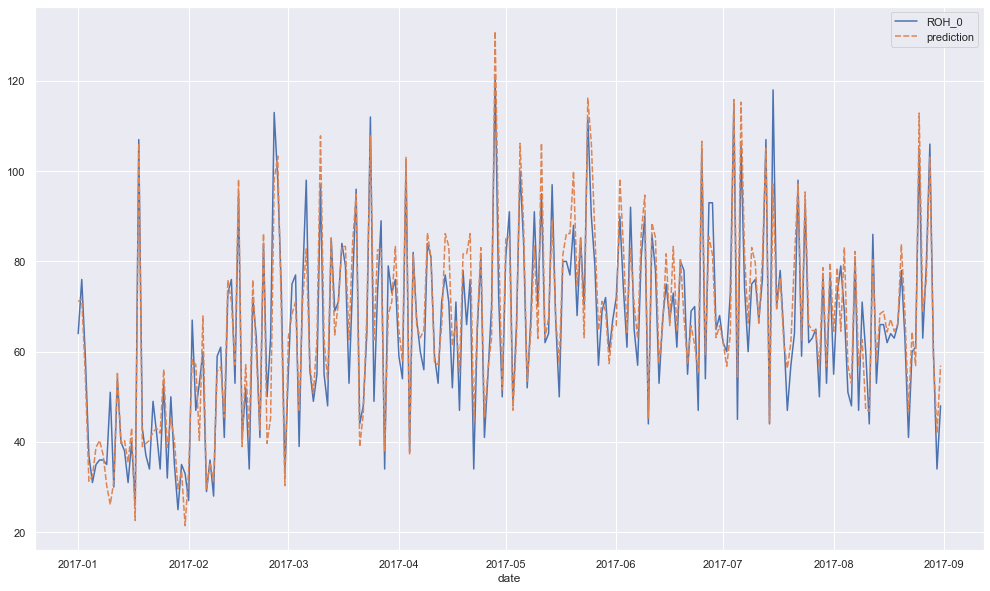

In [350]:
xg_current_best=xgb.train(params=best_params, dtrain=DTrain, num_boost_round=10)
res = iter_validation(df_test_ts,preprocessor=preprocessor_categorical,days_ahead=7,model=xg_current_best)

Test set RMSE: 8.629177


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

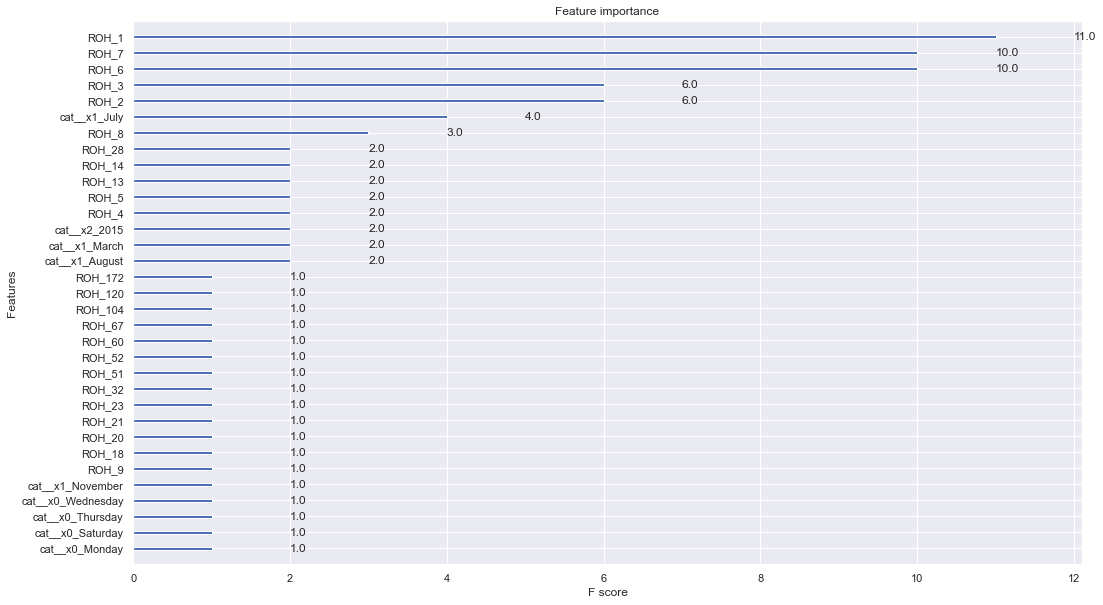

In [351]:
rmse = np.sqrt(mean_squared_error(y_test, xg_current_best.predict(data=Dtest)))
print("Test set RMSE: %f" % (rmse))
xgb.plot_importance(xg_current_best)

MAPE: 0.088493
RMSE: 44.305794
MAE: 5.315483


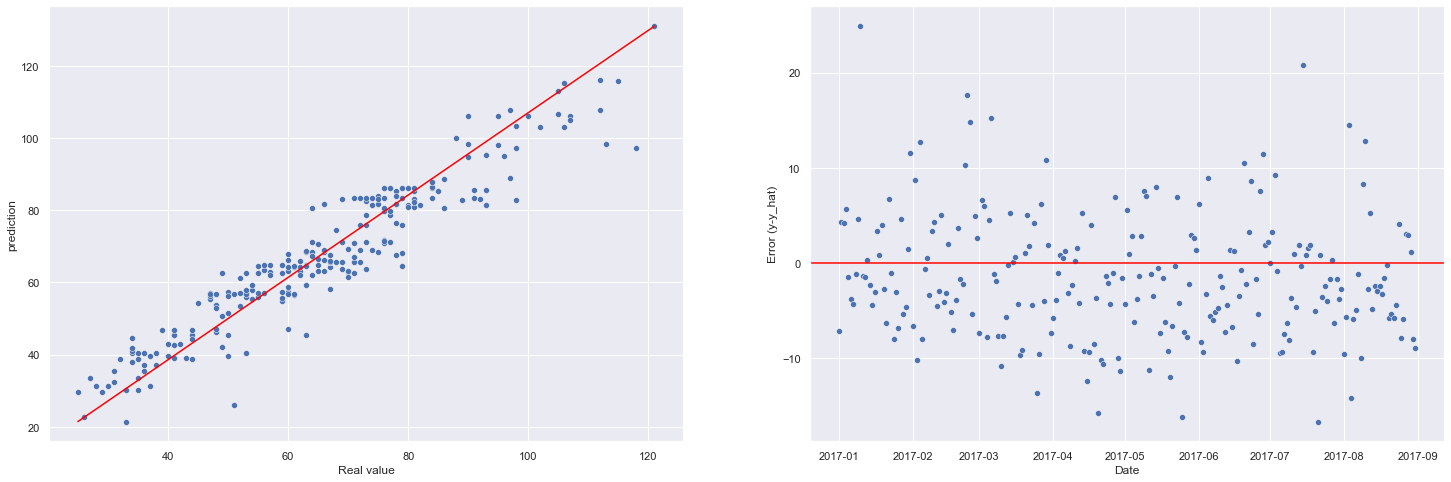

In [352]:

def plot_diagnostics(res):
    """[date real pred;]"""

    print("MAPE: %f" % (mean_absolute_percentage_error(res["ROH_0"],res['prediction'])))
    print("RMSE: %f" % mean_squared_error(res["ROH_0"],res['prediction'],squared=True))
    print("MAE: %f" % mean_absolute_error(res["ROH_0"],res['prediction']))


    # print("RMSE: %f" % mean_squared_error(res["ROH_0"],res['prediction'],squared=True))
    # print("MAE: %f" % mean_absolute_error(res["ROH_0"],res['prediction']))
    sns.set(rc = {'figure.figsize':(25,8)})
    fig, ax = plt.subplots(ncols=2)
    sns.scatterplot(data=res,x='ROH_0',y='prediction',ax=ax[0])
    sns.lineplot(x=[res['ROH_0'].min(),res['ROH_0'].max()],
                    y = [res['prediction'].min(),res['prediction'].max()],color='red',ax=ax[0])
    ax[0].set_xlabel('Real value');

    sns.scatterplot(x=res.index,y=res['ROH_0']-res['prediction'],ax=ax[1])
    ax[1].axhline(0,c='red')
    ax[1].set_xlabel('Date');
    ax[1].set_ylabel('Error (y-y_hat)');

plot_diagnostics(res)

## TODO:

- MLP as in the paper
- Clean up and modularise the notebook
- Own helper func.py and comment all functions
    - --> Streamlit with lots of exaplanation
    - Notebook is scrapped afterwards
- Explanation of implementation, methods, flaws and conclusions (streamlit)


In [353]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [354]:
X_mlp = df_sampled.iloc[:,7:181]
y_mlp = y.copy()
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_mlp, y_mlp, test_size=0.2, random_state=42)

[8.68101404e-01 8.36299249e-02 2.08710057e-02 8.26111864e-03
 5.14856682e-03 2.87720994e-03 2.13326489e-03 2.01571527e-03
 1.31106376e-03 7.30896776e-04]


<AxesSubplot:>

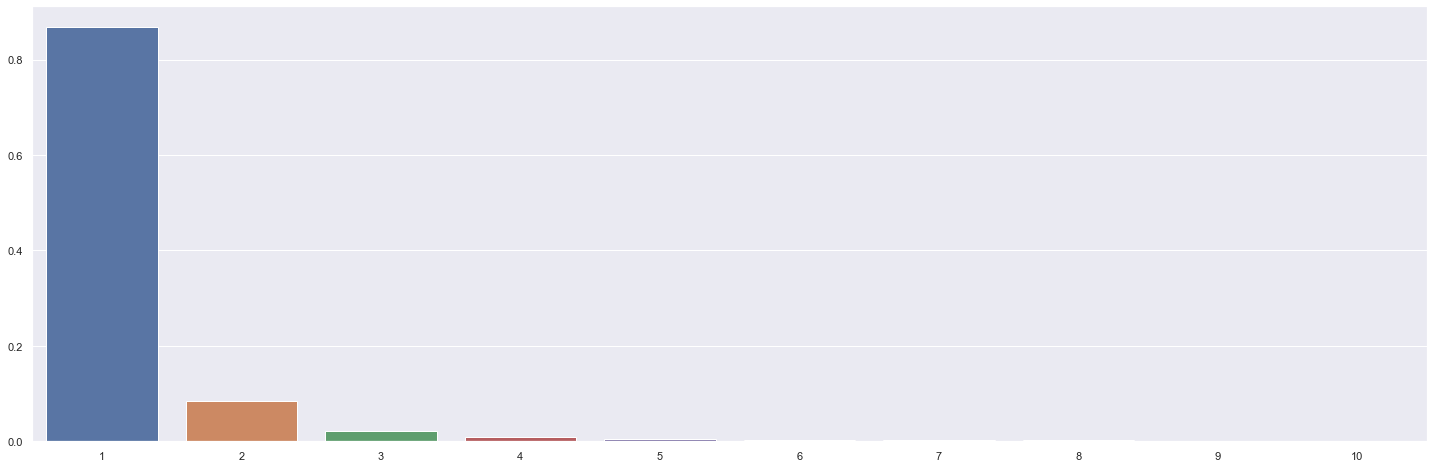

In [355]:
pca = PCA(n_components=10)
pca.fit(X_train_mlp)
print(pca.explained_variance_ratio_)
sns.barplot(x=np.arange(1,11),y=pca.explained_variance_ratio_)

In [356]:
# X_mlp = df_sampled.iloc[:,np.r_[7,10:181:10 ]]
X_mlp = df_sampled.iloc[:,7:181]
y_mlp = y.copy()
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_mlp, y_mlp, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_mlp = scaler.fit_transform(X_train_mlp)
# X_test_mlp = scaler.transform(X_test_mlp)

pipe = Pipeline([('scaler', StandardScaler()), ('PCA',PCA(n_components=15))])
X_train_mlp = pipe.fit_transform(X_train_mlp)
X_test_mlp = pipe.transform(X_test_mlp)

# pipe = Pipeline([('scaler', StandardScaler()), ('PCA',PCA(n_components=5))])
# X_train_mlp = pipe.fit_transform(X_train_mlp)
# X_test_mlp = pipe.transform(X_test_mlp)

In [357]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_mlp, y_train_mlp)

MAPE: 0.128378
RMSE: 113.065556
MAE: 8.216880


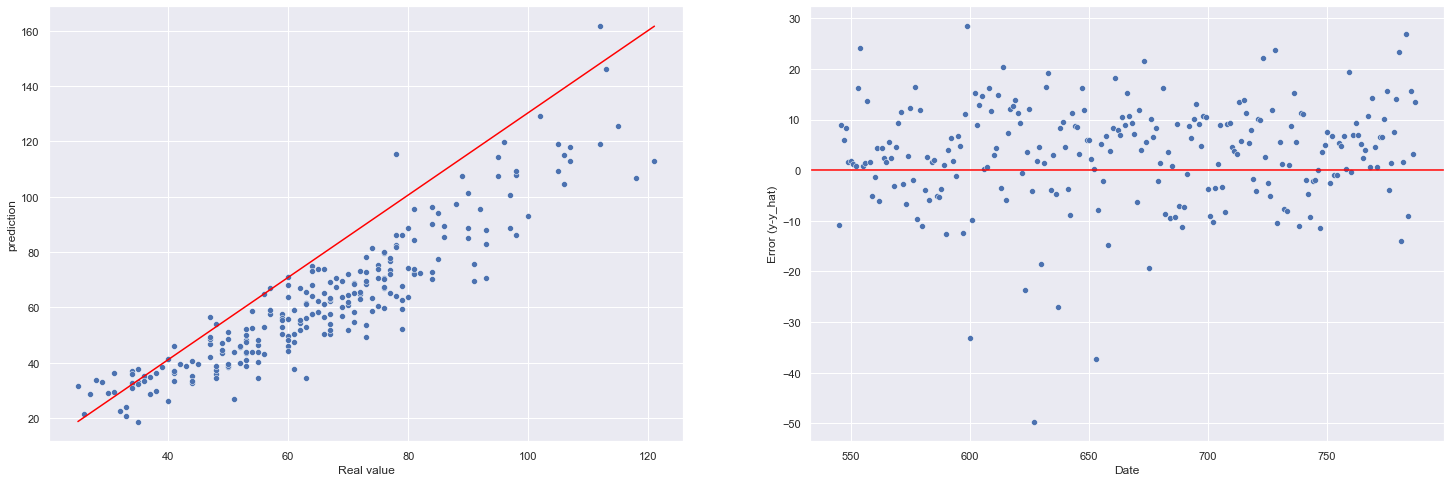

In [358]:
res_mlp = df_test_ts[["date",'ROH_0']]
# x_mlp_test_ts = df_test_ts.iloc[:,np.r_[8,11:182:10 ]]
x_mlp_test_ts = df_test_ts.iloc[:,8:182]
y_mlp_test_ts = df_test_ts['ROH_0']
x_mlp_test_ts = pipe.transform(x_mlp_test_ts)
res_mlp['prediction'] = regr.predict(x_mlp_test_ts) 
plot_diagnostics(res_mlp)

In [359]:
from sklearn.model_selection import GridSearchCV
param_grid = {
            'hidden_layer_sizes' : [2,4,6,8,10],
            'activation': ['relu','tanh'],
            'solver' : ['lbfgs'],
            'alpha':[0.0001,0.1,0.5]

        }     
mlp_model = MLPRegressor()
clf = GridSearchCV(mlp_model, param_grid, n_jobs=5, 
                   cv=4, 
                   scoring='neg_root_mean_squared_error',
                   verbose=2, refit=True)

clf.fit(X_train_mlp, y_train_mlp);

Fitting 4 folds for each of 30 candidates, totalling 120 fits


In [360]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').iloc[:4,3:].T

,10,0,12,5
std_score_time,0.001645,0.000432,0.000002,0.000009
param_activation,relu,relu,relu,relu
param_alpha,0.5,0.0001,0.5,0.1
param_hidden_layer_sizes,2,2,6,2
param_solver,lbfgs,lbfgs,lbfgs,lbfgs
params,"{'activation': 'relu', 'alpha': 0.5, 'hidden_l...","{'activation': 'relu', 'alpha': 0.0001, 'hidde...","{'activation': 'relu', 'alpha': 0.5, 'hidden_l...","{'activation': 'relu', 'alpha': 0.1, 'hidden_l..."
split0_test_score,-8.375789,-8.526745,-8.804941,-8.985981
split1_test_score,-9.591304,-9.969063,-9.745223,-9.582674
split2_test_score,-8.507974,-8.56167,-8.706559,-8.460471
split3_test_score,-8.714123,-8.797066,-8.732088,-9.187796


In [361]:
clf.best_params_

{'activation': 'relu',
 'alpha': 0.5,
 'hidden_layer_sizes': 2,
 'solver': 'lbfgs'}

MAPE: 0.089093
RMSE: 43.445969
MAE: 5.229289


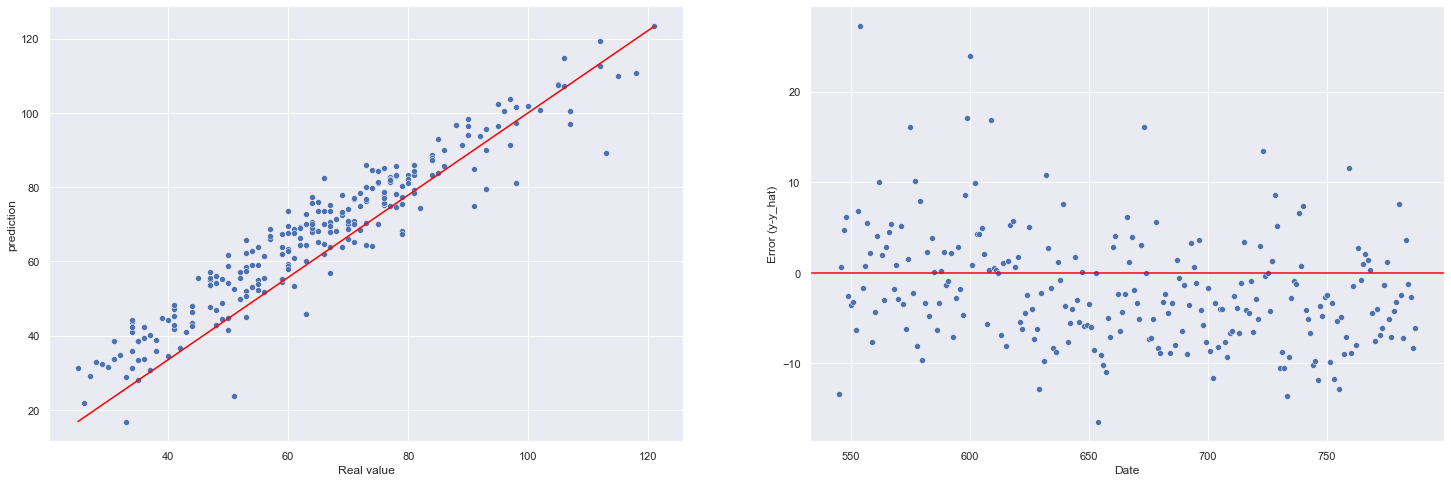

In [362]:
res_mlp['prediction'] = MLPRegressor().set_params(**clf.best_params_).fit(X_train_mlp, y_train_mlp).predict(x_mlp_test_ts) 
plot_diagnostics(res_mlp)